*"Bresenham's line algorithm is an algorithm that determines the points of an n-dimensional raster that should be selected in order to form a close approximation to a straight line between two points. It is commonly used to draw line primitives in a bitmap image (e.g. on a computer screen), as it uses only integer addition, subtraction and bit shifting, all of which are very cheap operations in standard computer architectures. It is an incremental error algorithm."* - [Wikipedia](https://en.wikipedia.org/wiki/Bresenham's_line_algorithm)

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as pch

In [57]:
def draw_pixel(x, y, ax):
    """1 pixel = 10 real pixels
    """
    ax.add_patch(pch.Rectangle((x - 0.5, y - 0.5), 1, 1, facecolor='lightgray', alpha=0.5))


# Adapted from https://gist.github.com/bert/1085538#file-plot_line-c
def bresenham(x0, y0, x1, y1, ax, show_err=True):
    x0 = int(x0)
    x1 = int(x1)
    y0 = int(y0)
    y1 = int(y1)
    plt.plot([x0, x1], [y0, y1], 'b')
    dx =  abs( x1 - x0 )
    sx = 1 if x0 < x1 else -1
    dy = -abs( y1 - y0 )
    sy = 1 if y0 < y1 else -1 
    err = dx + dy
    e2 = 0        
    while 1:
      draw_pixel(x0, y0, ax);
      if show_err: ax.text(x0, y0, '{}'.format(err), ha='center', va='center')
      if x0 == x1 and y0 == y1: break;
      e2 = 2 * err;
      if e2 >= dy:
        err += dy
        x0 += sx
      if e2 <= dx:
        err += dx
        y0 += sy 

The implementation above is the most compact I ran into, cleverly handling all the different octants outlined in https://en.wikipedia.org/wiki/Bresenham's_line_algorithm . It's a little hard to understand because it bundles some of the computations together.

[-0.5, 20, -0.5, 20]

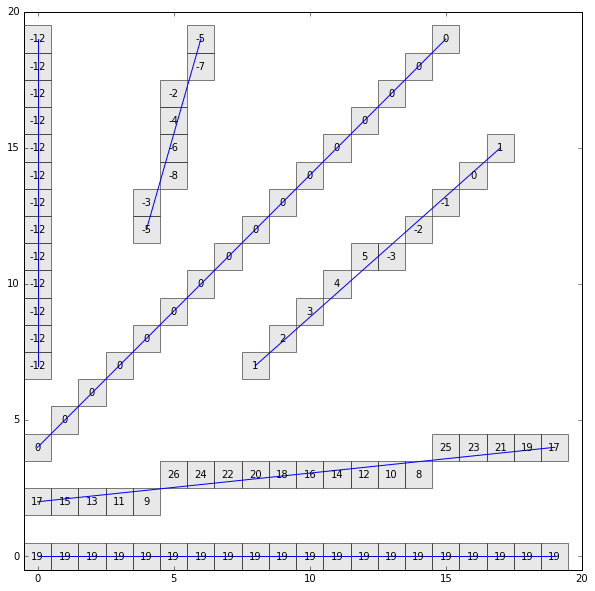

In [58]:
fig=plt.figure(figsize=(10, 10))
ax = fig.gca()

bresenham(x0=0, y0=0, x1=19, y1=0, ax=ax)
bresenham(x0=0, y0=2, x1=19, y1=4, ax=ax)
bresenham(x0=0, y0=4, x1=15, y1=19, ax=ax)
bresenham(x0=8, y0=7, x1=17, y1=15, ax=ax)
bresenham(x0=4, y0=12, x1=6, y1=19, ax=ax)
bresenham(x0=0, y0=7, x1=0, y1=19, ax=ax)

plt.setp(ax, xlim=(-0.5, 20), ylim=(-0.5, 20))

The above figure plots the ideal line and the quantized (pixelated) approximation the algorithm produces.
While you can work out the algorithm from first principles the above figure gives a good intuition of what the `err` variable in the algorithm is doing.  A positive value will generate a run of x-increments. A negative value will generate y-increments. `err` is a counter that says how many more x- or y-increments do we have to do before we start a y- or x- increment. 

Now this is all well and good, but I ran into an issue with Bresenham's algorithm. What I was doing was drawing an animated line, "growing" it from a start to an end position. The library for the screen device I was using supplies a Bresenham based line routine and I had the following problem:

[-0.5, 10, -0.5, 40]

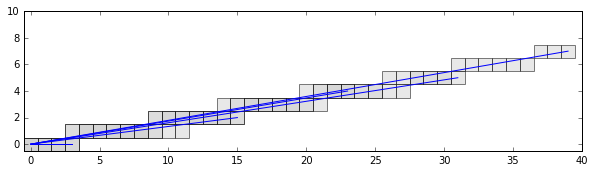

In [63]:
fig=plt.figure(figsize=(10, 2.5))
ax = fig.gca()

for f in [0.1, 0.4, 0.6, 0.8, 1.0]:
    bresenham(x0=0, y0=0, x1=39 * f, y1=7 * f, ax=ax, show_err=False)

plt.setp(ax, xlim=(-0.5, 40), ylim=(-0.5, 10))

It's a little subtle in un-animated form, but you can see it. The grown line is thicker than it normally would be when drawn in one go:

[-0.5, 10, -0.5, 40]

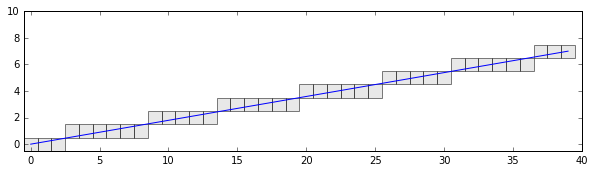

In [64]:
fig=plt.figure(figsize=(10, 2.5))
ax = fig.gca()

bresenham(x0=0, y0=0, x1=39, y1=7, ax=ax, show_err=False)

plt.setp(ax, xlim=(-0.5, 40), ylim=(-0.5, 10))

This was unacceptable from an aesthetic point of view and I needed to make a modification to the algorithm. The root cause of this thickening was that the end points of the line, due to integer rounding, would move above or below the ideal line, causing Bresenham's algorithm to do slightly different things. **What I needed was to keep the endpoints fixed but vary the pint at which the algorithm stopped.**

I did this by simply changing the termination condition for the algorithm as follows:

In [82]:
# Adapted from https://gist.github.com/bert/1085538#file-plot_line-c
def fractional_bresenham(x0, y0, x1, y1, ax, f, show_err=True):
    x0 = int(x0)
    x1 = int(x1)
    y0 = int(y0)
    y1 = int(y1)
    
    x_end = x0 + int(( x1 - x0 ) * f)
    y_end = y0 + int(( y1 - y0 ) * f)
    
    plt.plot([x0, x1], [y0, y1], 'b')
    dx =  abs( x1 - x0 )
    sx = 1 if x0 < x1 else -1
    dy = -abs( y1 - y0 )
    sy = 1 if y0 < y1 else -1 
    err = dx + dy
    e2 = 0        
    while 1:
      draw_pixel(x0, y0, ax);
      if show_err: ax.text(x0, y0, '{}'.format(err), ha='center', va='center')
      if dx > -dy: # Shallow
        if x0 == x_end:
            break
      else:
        if y0 == y_end :
            break

      e2 = 2 * err;
      if e2 >= dy:
        err += dy
        x0 += sx
      if e2 <= dx:
        err += dx
        y0 += sy 

[-0.5, 10, -0.5, 40]

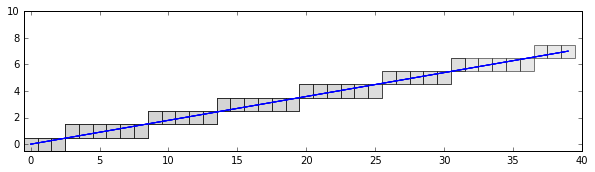

In [83]:
fig=plt.figure(figsize=(10, 2.5))
ax = fig.gca()

for f in [0.1, 0.4, 0.6, 0.8, 1.0]:
    fractional_bresenham(x0=0, y0=0, x1=39, y1=7, f=f, ax=ax, show_err=False)

plt.setp(ax, xlim=(-0.5, 40), ylim=(-0.5, 10))

[-0.5, 40, -0.5, 10]

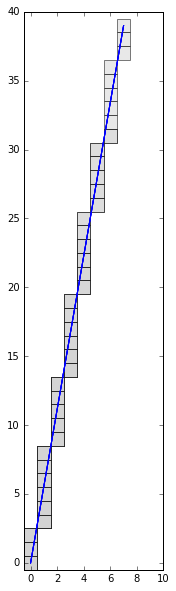

In [84]:
fig=plt.figure(figsize=(2.5, 10))
ax = fig.gca()

for f in [0.1, 0.4, 0.6, 0.8, 1.0]:
    fractional_bresenham(x0=0, y0=0, x1=7, y1=39, f=f, ax=ax, show_err=False)

plt.setp(ax, xlim=(-0.5, 10), ylim=(-0.5, 40))

[-40, 40, -40, 40]

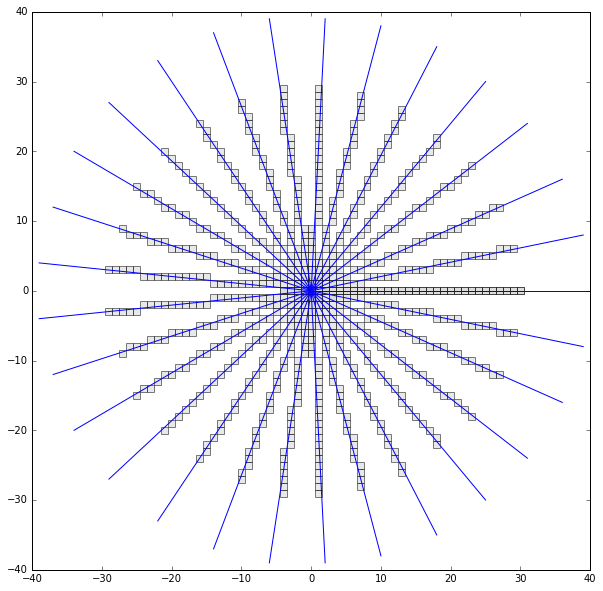

In [86]:
fig=plt.figure(figsize=(10, 10))
ax = fig.gca()

for theta in np.linspace(0, 2 * np.pi, 30):
    fractional_bresenham(x0=0, y0=0, x1=40 * np.cos( theta ), y1=40* np.sin( theta ), f=0.75, ax=ax, show_err=False)

plt.setp(ax, xlim=(-40, 40), ylim=(-40, 40))

Looks like we licked that problem.